In [2]:
# local scripts
import computation as comp # all functions to compute the stack thicknesses and boost spectrum
import optimization as opt # all functions to optimize the stack

# numerical computing
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import scipy.constants as const

# utilities
from time import time
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt
import seaborn as sns


SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
FIGSIZE = (10,8)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# General Overview

-We use the Transfer Matrix formalism, which is described in detail in Alex Millar's thesis. 

-The idea is to find optimal number of layers and thicknesses, such that the boost spectrum is maximized at a chosen wavelength

-This notebook will give the user an intuition of how different parameters affect the boost spectrum

# 1.  Understanding the construction of layers

In this section, we will understand how the thicknesses and refractive indices are distributed in different configurations

In [3]:
n1 = 1.4656 # SiO2
n2 = 1.9166 # Si3N4
d1 = 10e-9 # 10nm
d2 = d1 * (n1/n2)
nlayers = 10
chirp1 = 1
chirp2 = 1.5
chirp3 = 2


mirror = False

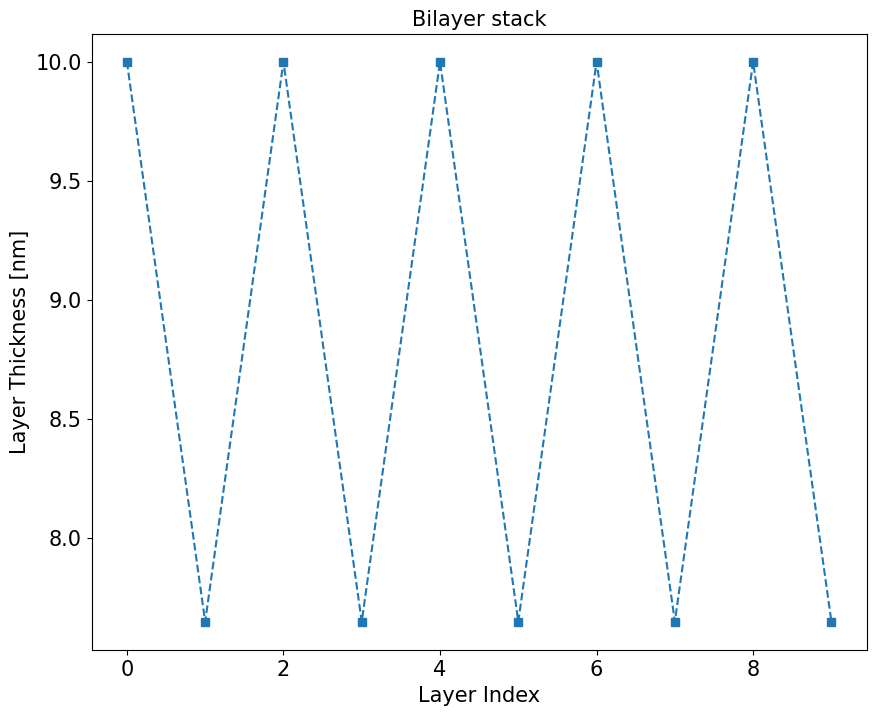

In [4]:
tlist = comp.make_ThickList(d1, d2, nlayers)
plt.figure(figsize=FIGSIZE)
plt.plot(tlist*1e9,marker='s',linestyle='--')
plt.xlabel("Layer Index")
plt.ylabel("Layer Thickness [nm]")
plt.title("Bilayer stack")
plt.show()

In a chirped stack, we have 

$$d_{n-1} = c \times d_{1}$$

where c is the chirp factor, the stack has $n$ layers with 0-indexing

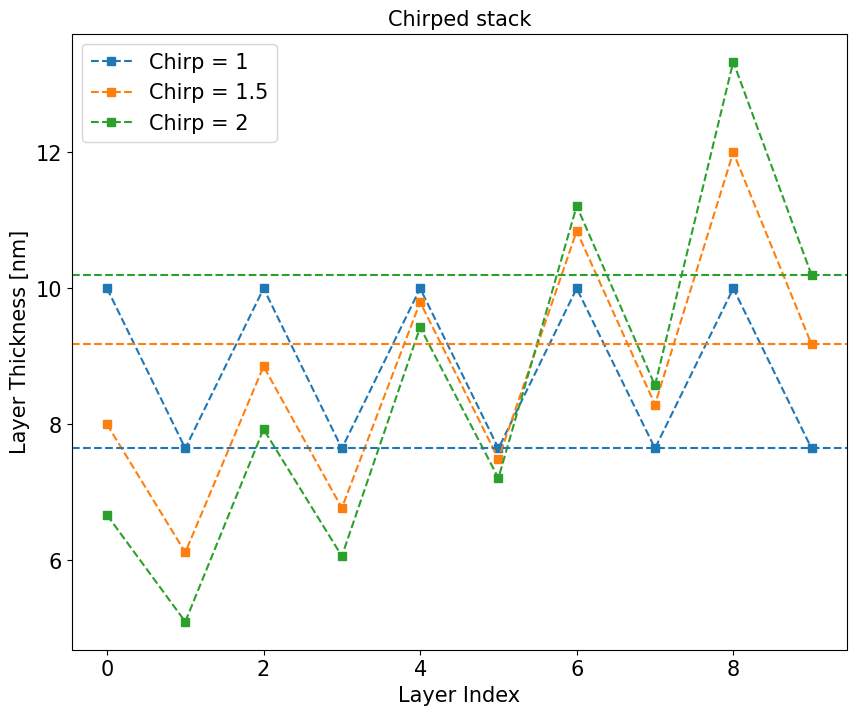

In [5]:
ctlist1 = comp.make_chirplist(d1, d2, n1, n2, nlayers, chirping_ = chirp1) # chirp = 1 is same as a bilayer stack
ctlist2 = comp.make_chirplist(d1, d2, n1, n2, nlayers, chirping_ = chirp2)
ctlist3 = comp.make_chirplist(d1, d2, n1, n2, nlayers, chirping_ = chirp3)


plt.figure(figsize=FIGSIZE)

plt.plot(ctlist1*1e9,marker='s',linestyle='--',label="Chirp = 1")
plt.plot(ctlist2*1e9,marker='s',linestyle='--',label="Chirp = 1.5")
plt.plot(ctlist3*1e9,marker='s',linestyle='--',label="Chirp = 2")

# note that the chirp relation holds true
plt.axhline(ctlist1[1]*chirp1*1e9,color='C0',linestyle='--')
plt.axhline(ctlist2[1]*chirp2*1e9,color='C1',linestyle='--')
plt.axhline(ctlist3[1]*chirp3*1e9,color='C2',linestyle='--')


plt.xlabel("Layer Index")
plt.ylabel("Layer Thickness [nm]")
plt.title("Chirped stack")
plt.legend()
plt.show()

# 2. Boost spectrum under different conditions

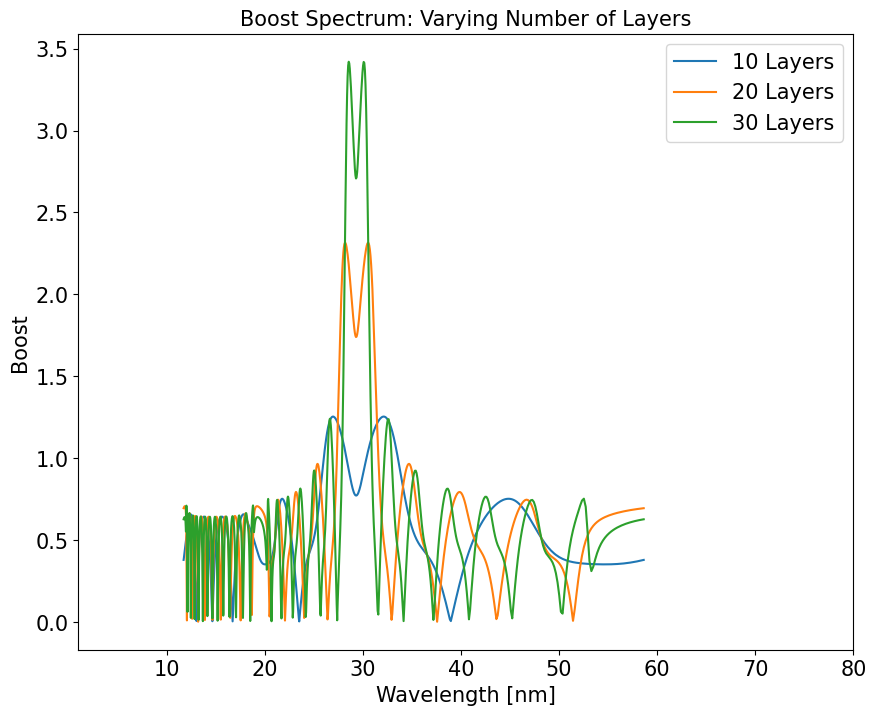

In [9]:
w1,boost1 = comp.solution_rightwave(n1,n2,d1,nLayers=10)
w2,boost2 = comp.solution_rightwave(n1,n2,d1,nLayers=20)
w3,boost3 = comp.solution_rightwave(n1,n2,d1,nLayers=30)

w1 = comp.freq_to_lamda(w1)
w2 = comp.freq_to_lamda(w2)
w3 = comp.freq_to_lamda(w3)


plt.figure(figsize=(10,8))

plt.plot(w1,boost1,label="10 Layers")
plt.plot(w2,boost2,label="20 Layers")
plt.plot(w3,boost3,label="30 Layers")

plt.legend()
plt.xlabel("Wavelength [nm]")
plt.ylabel("Boost")
plt.title("Boost Spectrum: Varying Number of Layers")
plt.xlim(1,80)
plt.show()

Increasing number of layers ---> Increased boost

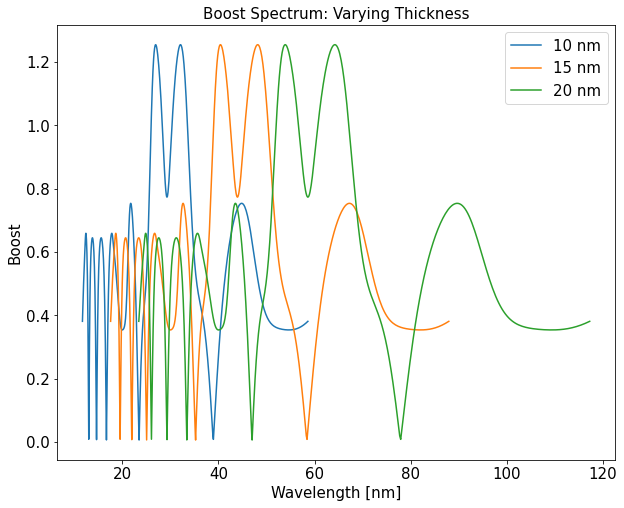

In [57]:
w1,boost1 = comp.solution_rightwave(n1,n2,d1,nlayers)
w2,boost2 = comp.solution_rightwave(n1,n2,d1+5e-9,nlayers)
w3,boost3 = comp.solution_rightwave(n1,n2,d1+10e-9,nlayers)

w1 = comp.freq_to_lamda(w1)
w2 = comp.freq_to_lamda(w2)
w3 = comp.freq_to_lamda(w3)


plt.figure(figsize=(10,8))

plt.plot(w1,boost1,label="10 nm")
plt.plot(w2,boost2,label="15 nm")
plt.plot(w3,boost3,label="20 nm")

plt.legend()
plt.xlabel("Wavelength [nm]")
plt.ylabel("Boost")
plt.title("Boost Spectrum: Varying Thickness")
plt.show()

higher thickness ---> centered around higher wavelength

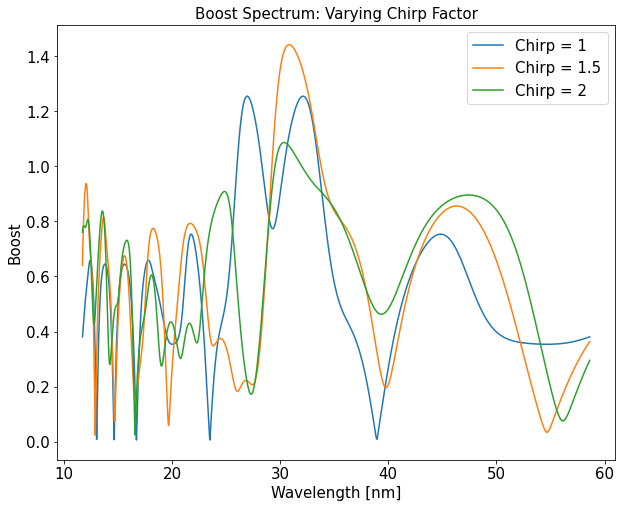

In [62]:
w1,boost1 = comp.solution_rightwave(n1,n2,d1,nlayers,chirp=chirp1)
w2,boost2 = comp.solution_rightwave(n1,n2,d1,nlayers,chirp=chirp2)
w3,boost3 = comp.solution_rightwave(n1,n2,d1,nlayers,chirp=chirp3)

w1 = comp.freq_to_lamda(w1)
w2 = comp.freq_to_lamda(w2)
w3 = comp.freq_to_lamda(w3)


plt.figure(figsize=(10,8))

plt.plot(w1,boost1,label="Chirp = 1")
plt.plot(w2,boost2,label="Chirp = 1.5")
plt.plot(w3,boost3,label="Chirp = 2")

plt.legend()
plt.xlabel("Wavelength [nm]")
plt.ylabel("Boost")
plt.title("Boost Spectrum: Varying Chirp Factor")
plt.show()

Chirping breaks the periodicity, the correct value could yield a favorable result

/home/umang/dielectricHaloscope/optimization-code/computation.py:22: RuntimeWarning: overflow encountered in double_scalars
  factor=0.5*((1/(n2**2))-(1/(n1**2)))


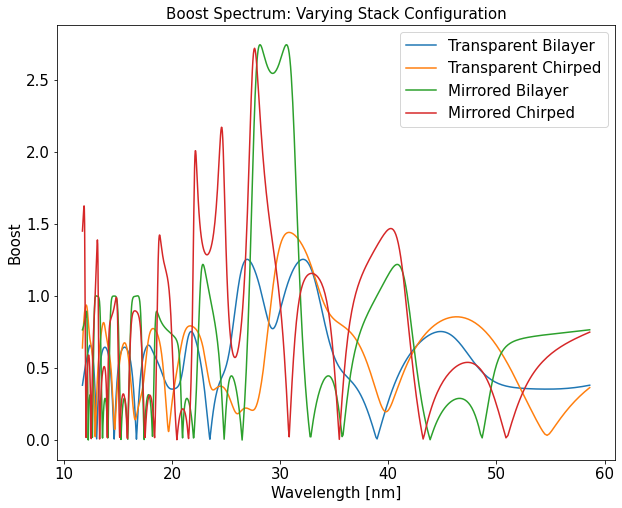

In [65]:
w1,boost1 = comp.solution_rightwave(n1,n2,d1,nlayers)
w2,boost2 = comp.solution_rightwave(n1,n2,d1,nlayers,chirp=chirp2)
w3,boost3 = comp.solution_rightwave(n1,n2,d1,nlayers,mirror=True)
w4,boost4 = comp.solution_rightwave(n1,n2,d1,nlayers,chirp=chirp2,mirror=True)


w1 = comp.freq_to_lamda(w1)
w2 = comp.freq_to_lamda(w2)
w3 = comp.freq_to_lamda(w3)
w4 = comp.freq_to_lamda(w4)



plt.figure(figsize=(10,8))

plt.plot(w1,boost1,label="Transparent Bilayer")
plt.plot(w2,boost2,label="Transparent Chirped")
plt.plot(w3,boost3,label="Mirrored Bilayer")
plt.plot(w4,boost4,label="Mirrored Chirped")


plt.legend()
plt.xlabel("Wavelength [nm]")
plt.ylabel("Boost")
plt.title("Boost Spectrum: Varying Stack Configuration")
plt.show()

This clearly demonstrated that using a mirrored stack with chirping will give us the ideal results